In [ ]:
path_preimages = "/Users/sakshisharma/Desktop/Mexico/Image/Pre-disaster"
path_postimages = "/Users/sakshisharma/Desktop/Mexico/Image/Post-disaster"
path_mbi_features = "/Users/sakshisharma/Desktop/Mexico/Feature/MBI"
NPY_files = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY"
path_labels = "/Users/sakshisharma/Desktop/Mexico/Label"

In [6]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image
import math

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms
from sklearn.metrics import f1_score




custom dataset class used to load data in batches during training for the model to learn -> load npy input arrays, matches label files, feeding data into the model -> 8 samples at a time and shuffle data at every epoch

reference: https://keras.io/api/utils/python_utils/#sequence-class

In [ ]:

class EarthquakeBuildingDamage(Dataset):
    def __init__(self, input_files, input_path, label_path, shuffle=True):
        self.input_files = input_files
        self.input_path = input_path
        self.label_path = label_path
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, index):
        filename = self.input_files[index]
        base = filename.replace("_input.npy", "")

        image_path = os.path.join(self.input_path, filename)
        label_path = os.path.join(self.label_path, base + ".tif")

        image_array = np.load(image_path)  # (512, 512, 10)
        label_array = tiff.imread(label_path)

        if label_array.ndim == 3:
            label_array = label_array.squeeze()

        if label_array.shape != (512, 512):
            print("Skipping file:", filename, "with label shape:", label_array.shape)   


        image_tensor = torch.from_numpy(image_array).permute(2, 0, 1).float()  # (10, 512, 512)
        label_tensor = torch.from_numpy(label_array).long()

        return image_tensor, label_tensor

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.input_files)


In [39]:
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# Example
Npy_files = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY"
path_labels = "/Users/sakshisharma/Desktop/Mexico/Label"
all_files = [f for f in os.listdir(Npy_files) if f.endswith("_input.npy")]

all_files.sort()

train_files, temp_files = train_test_split(all_files, test_size=0.30, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

train_dataset = EarthquakeBuildingDamage(train_files, Npy_files, path_labels)
val_dataset = EarthquakeBuildingDamage(val_files, Npy_files, path_labels)
test_dataset = EarthquakeBuildingDamage(test_files, Npy_files, path_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)



In [40]:
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Train files: 506
Validation files: 109
Test files: 109


In [ ]:
X_batch, Y_batch = next(iter(train_loader))  # dataloader!!
print("Input batch shape:", X_batch.shape)   # (batch_size, channels, 512, 512)
print("Label batch shape:", Y_batch.shape)   #(batch_size, 512, 512)


Input batch shape: torch.Size([8, 10, 512, 512])
Label batch shape: torch.Size([8, 512, 512])


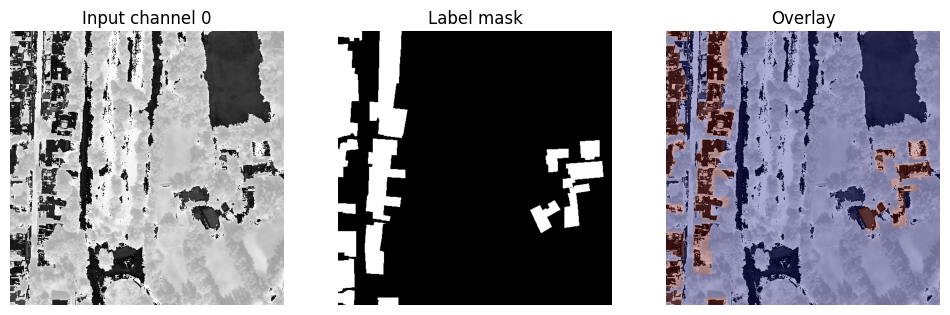

In [46]:
import matplotlib.pyplot as plt

# Take one sample from your dataset
image_tensor, label_tensor = train_dataset[0]

# Convert to numpy for plotting
image_np = image_tensor.numpy()  # shape: (10, 512, 512)
label_np = label_tensor.numpy()  # shape: (512, 512)

# Visualize first channel (or average over channels)
plt.figure(figsize=(12,5))

plt.subplot(1, 3, 1)
plt.title("Input channel 0")
plt.imshow(image_np[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Label mask")
plt.imshow(label_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(image_np[0], cmap='gray')
plt.imshow(label_np, cmap='jet', alpha=0.3)
plt.axis('off')

plt.show()


In [49]:
import numpy as np
import os
import tifffile as tiff

label_path = "/Users/sakshisharma/Desktop/Mexico/Label"
label_tif_files = [f for f in os.listdir(label_path) if f.endswith('.tif')]

all_classes = set()

for fname in label_tif_files:
    label = tiff.imread(os.path.join(label_path, fname))
    if label.ndim == 3:
        label = label.squeeze()

    unique_vals = np.unique(label)
    all_classes.update(unique_vals)

print("Unique classes in label data:", sorted(all_classes))


Unique classes in label data: [np.int8(0), np.int8(1), np.int8(2)]


number of classes in the dataset

In [50]:
import os
import numpy as np
import tifffile as tiff

label_files = os.listdir(path_labels)
all_labels = set()

for file_name in label_files:
    if not file_name.endswith(('.tif', '.tiff')):
        continue

    label_path = os.path.join(path_labels, file_name)
    try:
        label_image = tiff.imread(label_path)
    except Exception as e:
        print(f"Skipping {file_name}: {e}")
        continue

    unique_values = np.unique(label_image)
    all_labels.update(unique_values)

print("Unique damage classes found in dataset:", sorted(all_labels))


Unique damage classes found in dataset: [np.int8(0), np.int8(1), np.int8(2)]


Total pixel count per class


In [51]:
from collections import Counter

label_counts = Counter()

for file_name in os.listdir(path_labels):
    if not file_name.endswith('.tif'):
        continue
    label = tiff.imread(os.path.join(path_labels, file_name))
    unique, counts = np.unique(label, return_counts=True)
    label_counts.update(dict(zip(unique, counts)))

print("Total pixel count per class:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} pixels")


Total pixel count per class:
Class 0: 134504993 pixels
Class 1: 55197802 pixels
Class 2: 89461 pixels


| Class | Description           | Pixel Count     |
| ----- | --------------------- | --------------- |
| 0     | No damage             | **134,504,993** |
| 1     | Minor/Moderate damage | **55,197,802**  |
| 2     | Major damage          | **89,461**      |


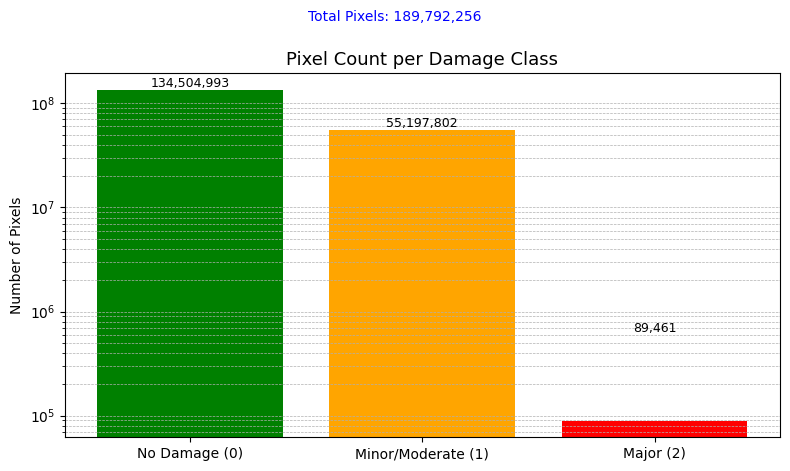

In [54]:
import matplotlib.pyplot as plt

# Data
classes = ['No Damage (0)', 'Minor/Moderate (1)', 'Major (2)']
pixel_counts = [134504993, 55197802, 89461]
total_pixels = sum(pixel_counts)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(classes, pixel_counts, color=['green', 'orange', 'red'])

# Add value labels
for bar, count in zip(bars, pixel_counts):
    plt.text(bar.get_x() + bar.get_width()/2.0, count + 500000, f'{count:,}', 
             ha='center', va='bottom', fontsize=9)

# Main title
plt.title("Pixel Count per Damage Class", fontsize=13)

# Add total pixel count below the plot title (not overlapping)
plt.figtext(0.5, 0.91, f"Total Pixels: {total_pixels:,}", ha="center", fontsize=10, color="blue")

# Axis labels
plt.ylabel("Number of Pixels")
plt.yscale("log")
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.88])  # Reserve space for figtext
plt.show()


UNET MODEL

